<a href="https://colab.research.google.com/github/ucaokylong/NLP_learning/blob/main/Aspect_based_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

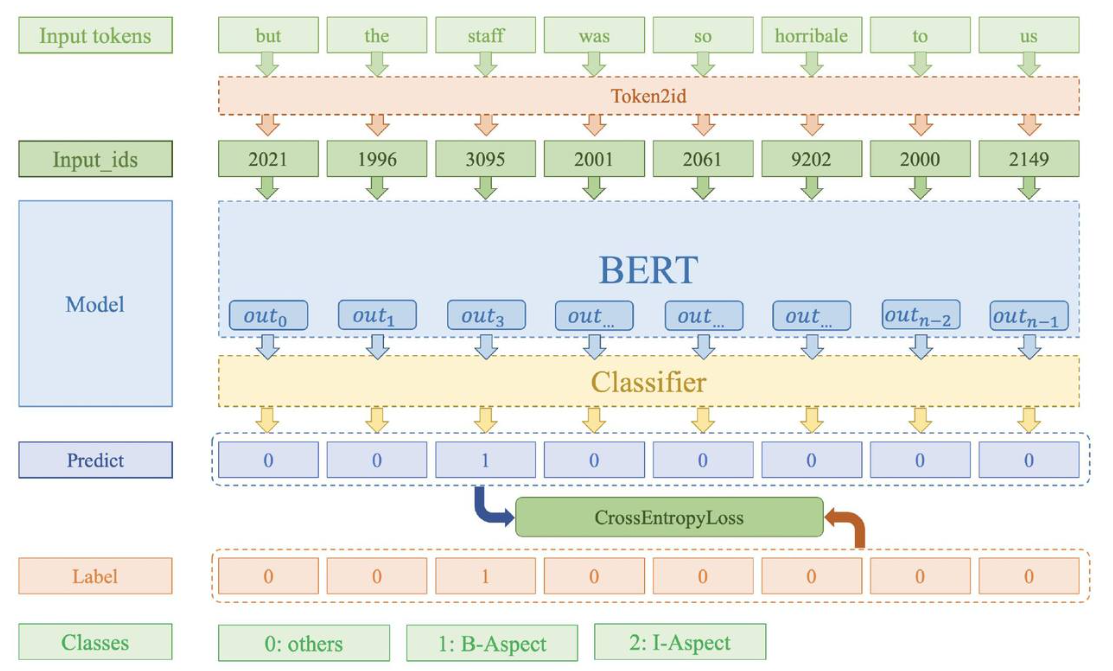

In [10]:
# Install lib
!pip install -q datasets==3.2.0

from datasets import load_dataset

ds = load_dataset("thainq107/abte-restaurants")


In [9]:
print(ds['train'][0])

{'Tokens': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us', '.'], 'Tags': ['0', '0', '1', '0', '0', '0', '0', '0', '0'], 'Polarities': ['-1', '-1', '0', '-1', '-1', '-1', '-1', '-1', '-1']}


In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def tokenize_and_align_labels(examples):
    tokenized_inputs = []
    labels = []

    # examples['Tokens'] là list of lists khi batched=True
    for tokens, tags in zip(examples['Tokens'], examples['Tags']):
        # tokens và tags đã là list sẵn, không cần parsing

        bert_tokens = []
        bert_tags = []
        for i in range(len(tokens)):
            # Tokenize từng token
            t = tokenizer.tokenize(tokens[i])
            bert_tokens += t
            # Convert tag từ string sang int và nhân bản cho subwords
            bert_tags += [int(tags[i])] * len(t)

        # Convert tokens sang IDs
        bert_ids = tokenizer.convert_tokens_to_ids(bert_tokens)

        tokenized_inputs.append(bert_ids)
        labels.append(bert_tags)

    return {
        'input_ids': tokenized_inputs,
        'labels': labels
    }

# Apply preprocessing
preprocessed_ds = ds.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/3602 [00:00<?, ? examples/s]

Map:   0%|          | 0/1119 [00:00<?, ? examples/s]

In [12]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


In [13]:
# Install lib
!pip install -q seqeval==1.2.2
import numpy as np
from seqeval.metrics import accuracy_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [str(p) for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [str(l) for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = accuracy_score(true_predictions, true_labels)
    return {"accuracy": results}


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [14]:
from transformers import AutoModelForTokenClassification

id2label = {
    0: "O",
    1: "B-Term",
    2: "I-Term"
}

label2id = {
    "O": 0,
    "B-Term": 1,
    "I-Term": 2
}

model = AutoModelForTokenClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=3, id2label=id2label, label2id=label2id
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
import os
os.environ['WANDB_DISABLED'] = 'true'
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="abte-restaurants-distilbert-base-uncased",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=preprocessed_ds["train"],
    eval_dataset=preprocessed_ds["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.178481,0.934317
2,No log,0.193533,0.942877
3,0.142500,0.213958,0.942207
4,0.142500,0.228516,0.942522
5,0.030000,0.237812,0.943311


TrainOutput(global_step=1130, training_loss=0.07883766731329724, metrics={'train_runtime': 135.5476, 'train_samples_per_second': 132.868, 'train_steps_per_second': 8.337, 'total_flos': 241258883931900.0, 'train_loss': 0.07883766731329724, 'epoch': 5.0})

In [22]:
from transformers import pipeline

# Nếu model được save trong output_dir từ TrainingArguments
token_classifier = pipeline(
    task="token-classification",
    model="/content/abte-restaurants-distilbert-base-uncased/checkpoint-1130",  # ← Bỏ /checkpoint-1130
    aggregation_strategy="simple"
)

test_sentence = 'The bread is top notch as well'
results = token_classifier(test_sentence)
print(results)
print(results[0]['word'])

Device set to use cuda:0


[{'entity_group': 'Term', 'score': np.float32(0.9247125), 'word': 'bread', 'start': 4, 'end': 9}]
bread


## Aspect Term Sentiment Classification

In [23]:
# Install lib
!pip install -q datasets==3.2.0

from datasets import load_dataset

ds = load_dataset("thainq107/abte-restaurants")


In [25]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def tokenize_and_align_labels(examples):
    sentences, sentence_tags = [], []
    labels = []

    for tokens, pols in zip(examples['Tokens'], examples['Polarities']):
        # tokens và pols đã là list, KHÔNG cần string processing

        bert_tokens = []
        bert_att = []
        pols_label = 0

        for i in range(len(tokens)):
            t = tokenizer.tokenize(tokens[i])
            bert_tokens += t
            if int(pols[i]) != -1:
                bert_att += t
                pols_label = int(pols[i])

        sentences.append(" ".join(bert_tokens))
        sentence_tags.append(" ".join(bert_att))
        labels.append(pols_label)

    # ✅ Bỏ return_tensors="pt" để tránh lỗi PyTorch
    tokenized_inputs = tokenizer(
        sentences,
        sentence_tags,
        padding=True,
        truncation=True
        # return_tensors="pt"  # ← BỎ dòng này
    )
    tokenized_inputs['labels'] = labels
    return tokenized_inputs

preprocessed_ds = ds.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/3602 [00:00<?, ? examples/s]

Map:   0%|          | 0/1119 [00:00<?, ? examples/s]

In [26]:
# Install lib
!pip install -q evaluate==0.4.3

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.2 MB/s eta 0:00:00


In [27]:
from transformers import AutoModelForSequenceClassification

id2label = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
label2id = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
import os
from transformers import TrainingArguments, Trainer

os.environ['WANDB_DISABLED'] = 'true'

training_args = TrainingArguments(
    output_dir="absa-restaurants-distilbert-base-uncased",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=preprocessed_ds["train"],
    eval_dataset=preprocessed_ds["test"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.598165,0.768543
2,No log,0.550360,0.778374
3,0.618700,0.522102,0.811439
4,0.618700,0.523155,0.806077
5,0.320400,0.537515,0.809651


TrainOutput(global_step=1130, training_loss=0.44016889386472446, metrics={'train_runtime': 297.934, 'train_samples_per_second': 60.45, 'train_steps_per_second': 3.793, 'total_flos': 689416103009232.0, 'train_loss': 0.44016889386472446, 'epoch': 5.0})

In [31]:
from transformers import pipeline

token_classifier = pipeline(
    task="token-classification",
    model="/content/abte-restaurants-distilbert-base-uncased/checkpoint-1130",  # ← Bỏ /checkpoint-1130
    aggregation_strategy="simple"
)
# token_classifier = pipeline(
#     model="thainq107/abte-restaurants-distilbert-base-uncased",
#     aggregation_strategy="simple"
# )

classifier = pipeline(
    task="text-classification",
    model="/content/absa-restaurants-distilbert-base-uncased/checkpoint-1130"
    # model="thainq107/absa-restaurants-distilbert-base-uncased"
)

test_sentence = 'You are dedicated but you are ugly'
results = token_classifier(test_sentence)
sentence_tags = " ".join([result['word'] for result in results])
pred_label = classifier(f'{test_sentence}[SEP]{sentence_tags}')
sentence_tags, pred_label
# {'bread', [{'label': 'Positive', 'score': 0.9864555597305298}]}


Device set to use cuda:0
Device set to use cuda:0


('', [{'label': 'Negative', 'score': 0.9641320109367371}])